## *** Import necessary libraries***

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

## ***Load the data and Edit Data***

In [4]:
url = 'E:\\MLSC Data Science\\Graduation Project Part 2\\E-commerce_data.xlsx'
customers_df = pd.read_excel(url, sheet_name='customers')
genders_df = pd.read_excel(url, sheet_name='genders')
cities_df = pd.read_excel(url, sheet_name='cities')
transactions_df = pd.read_excel(url, sheet_name='transactions')
branches_df = pd.read_excel(url, sheet_name='branches')
merchants_df = pd.read_excel(url, sheet_name='merchants')

In [5]:
transactions_df.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6


In [6]:
customers_df.head()

,customer_id,join_date,city_id,gender_id
0,1,2022-01-08,7,1
1,2,2023-05-02,20,2
2,3,2023-05-14,15,1
3,4,2022-11-25,11,2
4,5,2023-04-26,8,1


## ***Merge data***

In [8]:
customers_merged = customers_df.merge(genders_df, on='gender_id', how='left').merge(cities_df, on='city_id', how='left')
transactions_merged = transactions_df.merge(branches_df, on='branch_id', how='left').merge(merchants_df, on='merchant_id', how='left')

In [9]:
customers_merged.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name
0,1,2022-01-08,7,1,Male,Mansoura
1,2,2023-05-02,20,2,Female,Sohag
2,3,2023-05-14,15,1,Male,Aswan
3,4,2022-11-25,11,2,Female,Ismailia
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra


In [10]:
transactions_merged.head()

,transaction_id,customer_id,transaction_date,transaction_status,coupon_name,burn_date,branch_id,merchant_id,merchant_name
0,1,733,2024-05-11,subscribed,uNY-568,NaT,7,7,Berry-Anderson
1,2,631,2023-05-15,burned,kBx-219,2023-06-04,5,9,"Campbell, Shaffer and Martinez"
2,3,309,2022-11-13,subscribed,PLG-122,NaT,7,7,Berry-Anderson
3,4,695,2024-01-26,subscribed,Wzf-897,NaT,2,18,Lewis LLC
4,5,288,2022-10-12,burned,qGb-428,2022-11-20,6,15,Butler-Gomez


### ***Aggregate transaction data per customer***

In [12]:
transaction_features = transactions_merged.groupby('customer_id').agg(
    total_transactions=('transaction_id', 'count'),
    last_transaction=('transaction_date', 'max'),
    coupon_usage=('coupon_name', 'count'),
    subscribed_count=('transaction_status', lambda x: (x == 'subscribed').sum())
).reset_index()

In [13]:
transaction_features['recency_days'] = (pd.to_datetime('today') - pd.to_datetime(transaction_features['last_transaction'])).dt.days
transaction_features['frequency'] = transaction_features['total_transactions'] / transaction_features['recency_days'].replace(0, np.nan) * 30  # monthly frequency

In [14]:
final_data = customers_merged.merge(transaction_features, on='customer_id', how='left')

In [15]:
final_data.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,last_transaction,coupon_usage,subscribed_count,recency_days,frequency
0,1,2022-01-08,7,1,Male,Mansoura,7.0,2024-05-26,7.0,4.0,119.0,1.764706
1,2,2023-05-02,20,2,Female,Sohag,3.0,2023-10-21,3.0,2.0,337.0,0.267062
2,3,2023-05-14,15,1,Male,Aswan,5.0,2024-07-05,5.0,4.0,79.0,1.898734
3,4,2022-11-25,11,2,Female,Ismailia,1.0,2023-01-15,1.0,1.0,616.0,0.048701
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,2024-07-02,4.0,1.0,82.0,1.463415


In [16]:
final_data.shape

(1000, 12)

In [17]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   customer_id         1000 non-null   int64         
 1   join_date           1000 non-null   datetime64[ns]
 2   city_id             1000 non-null   int64         
 3   gender_id           1000 non-null   int64         
 4   gender_name         1000 non-null   object        
 5   city_name           1000 non-null   object        
 6   total_transactions  989 non-null    float64       
 7   last_transaction    989 non-null    datetime64[ns]
 8   coupon_usage        989 non-null    float64       
 9   subscribed_count    989 non-null    float64       
 10  recency_days        989 non-null    float64       
 11  frequency           989 non-null    float64       
dtypes: datetime64[ns](2), float64(5), int64(3), object(2)
memory usage: 93.9+ KB


In [18]:
final_data.describe()

,customer_id,join_date,city_id,gender_id,total_transactions,last_transaction,coupon_usage,subscribed_count,recency_days,frequency
count,1000.000000,1000,1000.000000,1000.000000,989.000000,989,989.000000,989.000000,989.000000,989.000000
mean,500.500000,2023-01-15 07:29:16.800000,10.136000,1.491000,5.055612,2024-03-30 01:47:44.711830016,5.055612,2.511628,175.925177,1.305267
min,1.000000,2021-07-18 00:00:00,1.000000,1.000000,1.000000,2021-10-02 00:00:00,1.000000,0.000000,70.000000,0.027624
25%,250.750000,2022-04-08 18:00:00,5.000000,1.000000,3.000000,2024-02-22 00:00:00,3.000000,1.000000,86.000000,0.588235
50%,500.500000,2023-01-05 12:00:00,10.000000,1.000000,5.000000,2024-05-20 00:00:00,5.000000,2.000000,125.000000,1.129032
75%,750.250000,2023-10-27 00:00:00,15.000000,2.000000,6.000000,2024-06-28 00:00:00,6.000000,3.000000,213.000000,1.855670
max,1000.000000,2024-07-13 00:00:00,20.000000,2.000000,14.000000,2024-07-14 00:00:00,14.000000,9.000000,1086.000000,6.000000
std,288.819436,NaN,5.895953,0.500169,2.273759,NaN,2.273759,1.606892,135.162649,0.937544


## ***Check Duplicated Values***

In [20]:
final_data.duplicated().sum()

0

## ***Check Null Values***

In [22]:
final_data.isnull().sum()

customer_id            0
join_date              0
city_id                0
gender_id              0
gender_name            0
city_name              0
total_transactions    11
last_transaction      11
coupon_usage          11
subscribed_count      11
recency_days          11
frequency             11
dtype: int64

## ***Handling missing values***

In [24]:
final_data.fillna({
    'recency_days': final_data['recency_days'].max(),
    'total_transactions': final_data['total_transactions'].mean(),
    'last_transaction': final_data['last_transaction'].mean(),
    'frequency': final_data['frequency'].mean(),
    'coupon_usage': 0, 'subscribed_count': 0},
inplace=True)

In [25]:
final_data.isnull().sum()

customer_id           0
join_date             0
city_id               0
gender_id             0
gender_name           0
city_name             0
total_transactions    0
last_transaction      0
coupon_usage          0
subscribed_count      0
recency_days          0
frequency             0
dtype: int64

## ***Encoding categorical variables***

In [27]:
final_data['gender_encoded'] = final_data['gender_name'].map({'Male': 0, 'Female': 1})
final_data['city_encoded'] = final_data['city_name'].astype('category').cat.codes

In [28]:
final_data.head()

,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,last_transaction,coupon_usage,subscribed_count,recency_days,frequency,gender_encoded,city_encoded
0,1,2022-01-08,7,1,Male,Mansoura,7.0,2024-05-26,7.0,4.0,119.0,1.764706,0,11
1,2,2023-05-02,20,2,Female,Sohag,3.0,2023-10-21,3.0,2.0,337.0,0.267062,1,16
2,3,2023-05-14,15,1,Male,Aswan,5.0,2024-07-05,5.0,4.0,79.0,1.898734,0,1
3,4,2022-11-25,11,2,Female,Ismailia,1.0,2023-01-15,1.0,1.0,616.0,0.048701,1,10
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,2024-07-02,4.0,1.0,82.0,1.463415,0,7


## ***Feature selection***

In [30]:
features = ['total_transactions', 'coupon_usage', 'subscribed_count','recency_days', 'frequency', 'subscribed_count', 'gender_encoded', 'city_encoded']

## ***Standardizing the data***

In [32]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_data[features])

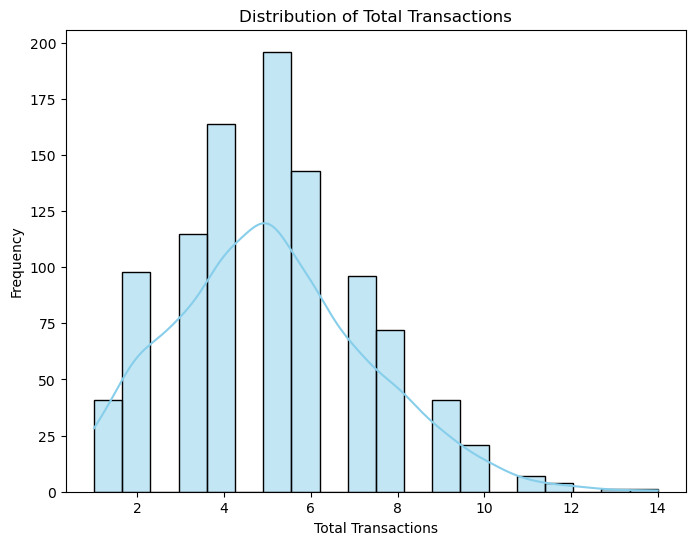

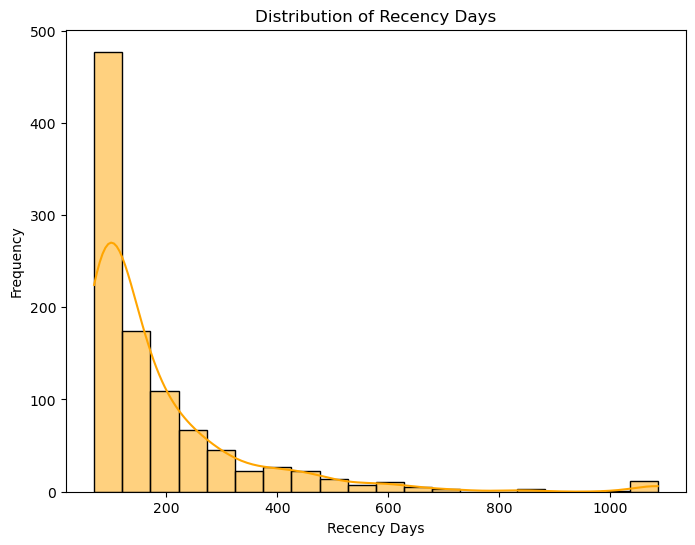

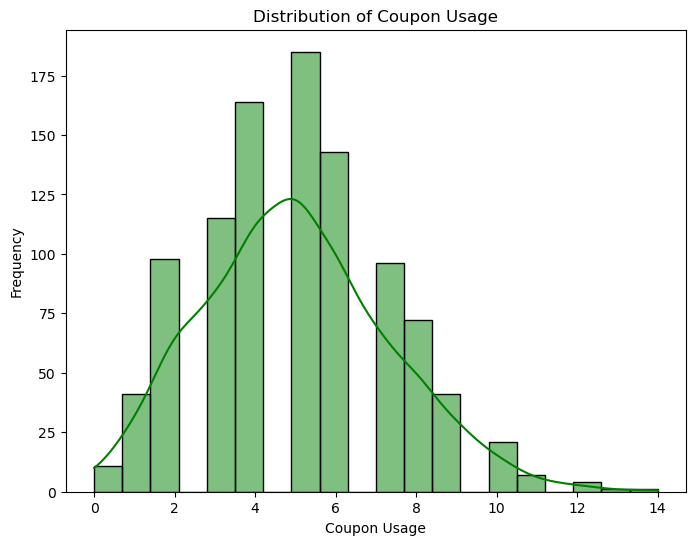

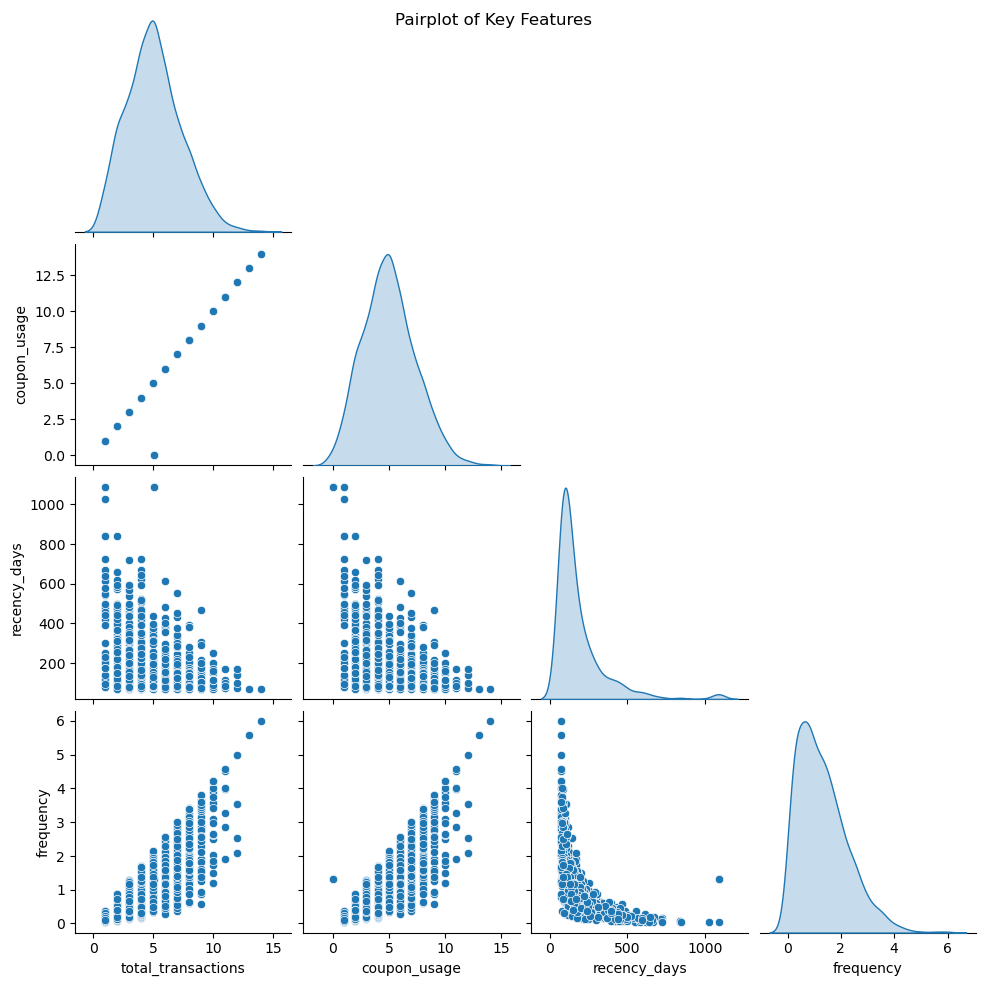

In [33]:
# Visualize distribution of total transactions
plt.figure(figsize=(8, 6))
sns.histplot(final_data['total_transactions'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Total Transactions')
plt.xlabel('Total Transactions')
plt.ylabel('Frequency')
plt.show()

# Visualize recency distribution
plt.figure(figsize=(8, 6))
sns.histplot(final_data['recency_days'], bins=20, kde=True, color='orange')
plt.title('Distribution of Recency Days')
plt.xlabel('Recency Days')
plt.ylabel('Frequency')
plt.show()

# Visualize coupon usage distribution
plt.figure(figsize=(8, 6))
sns.histplot(final_data['coupon_usage'], bins=20, kde=True, color='green')
plt.title('Distribution of Coupon Usage')
plt.xlabel('Coupon Usage')
plt.ylabel('Frequency')
plt.show()

sns.pairplot(final_data[['total_transactions', 'coupon_usage', 'recency_days', 'frequency']], corner=True, diag_kind='kde')
plt.suptitle('Pairplot of Key Features')
plt.show()

## ***Elbow method***

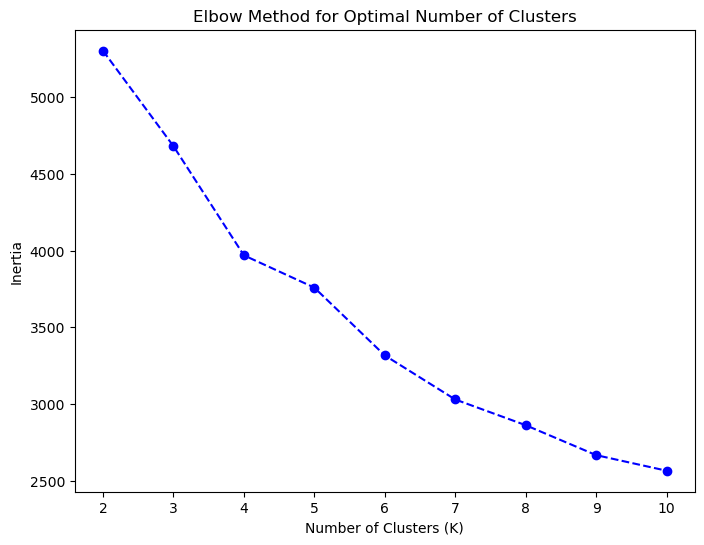

In [35]:
inertia = []
K = range(2, 11) 

for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(scaled_features)
    inertia.append(kmeans_temp.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(K, inertia, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.show()

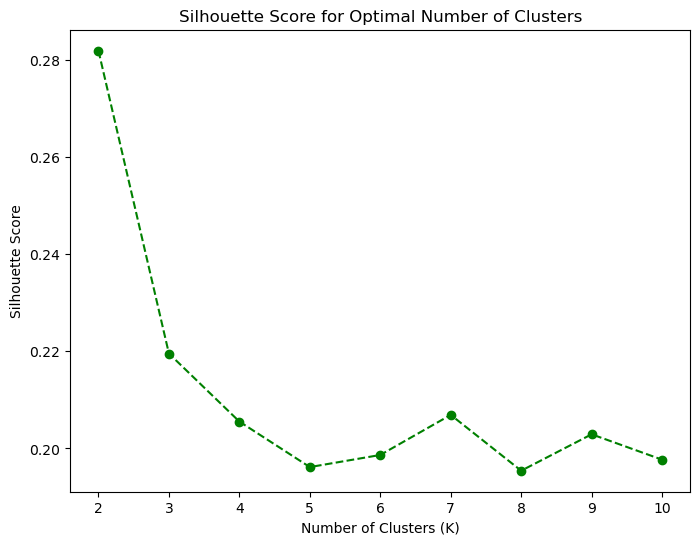

In [36]:
# Calculate silhouette score for different cluster numbers
silhouette_scores = []

for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans_temp.fit_predict(scaled_features)
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(8, 6))
plt.plot(K, silhouette_scores, marker='o', linestyle='--', color='green')
plt.title('Silhouette Score for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

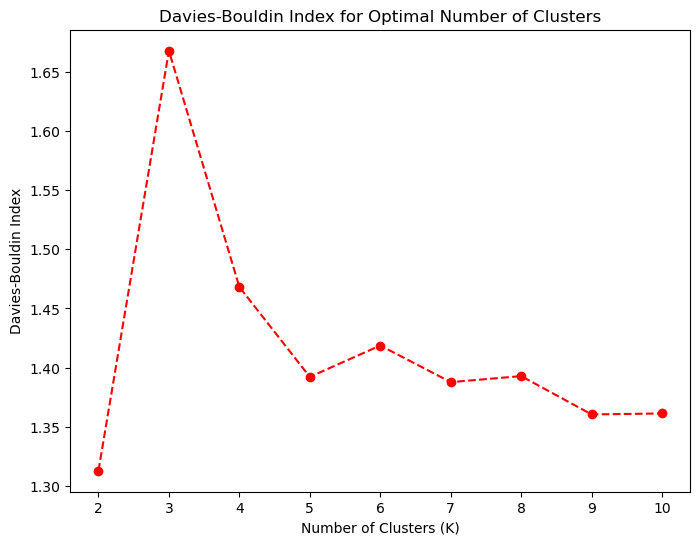

In [37]:
# Davies-Bouldin Index for different cluster numbers
from sklearn.metrics import davies_bouldin_score

db_scores = []

for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans_temp.fit_predict(scaled_features)
    db_index = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_index)

# Plot Davies-Bouldin Index
plt.figure(figsize=(8, 6))
plt.plot(K, db_scores, marker='o', linestyle='--', color='red')
plt.title('Davies-Bouldin Index for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

In [38]:
k_optimal = 2

kmeans = KMeans(n_clusters=k_optimal, random_state=42)
final_data['cluster'] = kmeans.fit_predict(scaled_features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features)

final_data_with_clusters = pd.concat([final_data, scaled_features_df], axis=1)
print(final_data_with_clusters.head())

   customer_id  join_date  city_id  gender_id gender_name  \
0            1 2022-01-08        7          1        Male   
1            2 2023-05-02       20          2      Female   
2            3 2023-05-14       15          1        Male   
3            4 2022-11-25       11          2      Female   
4            5 2023-04-26        8          1        Male   

             city_name  total_transactions last_transaction  coupon_usage  \
0             Mansoura                 7.0       2024-05-26           7.0   
1                Sohag                 3.0       2023-10-21           3.0   
2                Aswan                 5.0       2024-07-05           5.0   
3             Ismailia                 1.0       2023-01-15           1.0   
4  El-Mahalla El-Kubra                 4.0       2024-07-02           4.0   

   subscribed_count  ...  city_encoded  cluster  total_transactions  \
0               4.0  ...            11        0            0.860320   
1               2.0  ...    

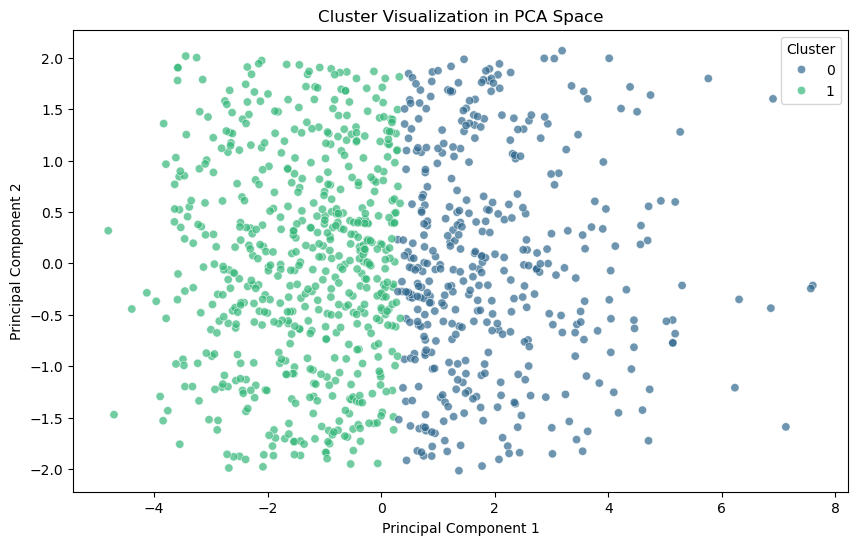

In [39]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaled_features) 

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = final_data_with_clusters['cluster']

# Visualize clusters in PCA space
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=pca_df, palette='viridis', alpha=0.7)
plt.title('Cluster Visualization in PCA Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

Cluster Centers:
   total_transactions  coupon_usage  subscribed_count  recency_days  \
0            7.093596      7.093596          3.901478    124.692118   
1            3.662646      3.569024          1.515152    227.796296   

   frequency  subscribed_count  gender_encoded  city_encoded  
0   2.054280          3.901478        0.482759      9.320197  
1   0.793315          1.515152        0.496633      9.570707  


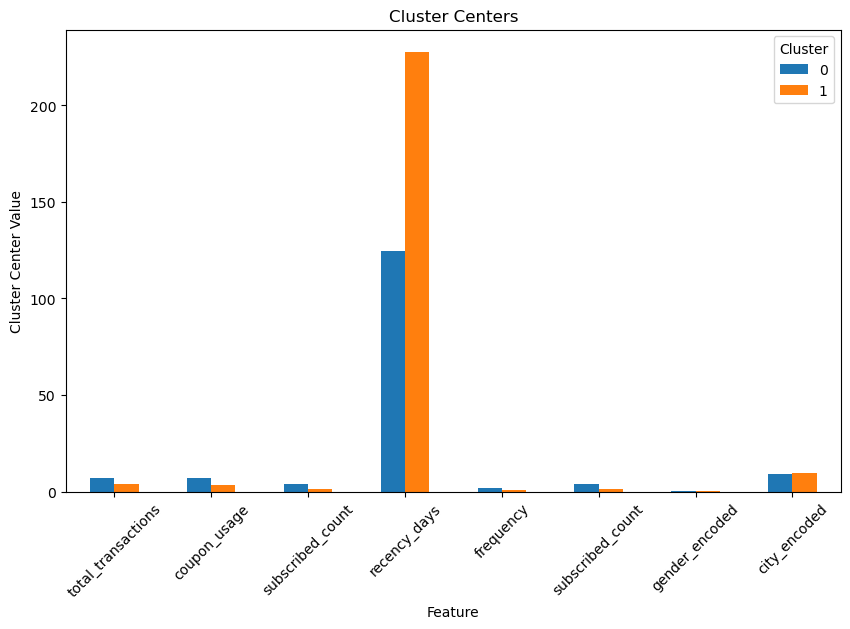

In [40]:
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Cluster Centers:")
print(cluster_centers)

cluster_centers.T.plot(kind='bar', figsize=(10, 6))  # Transpose to match the number of clusters for plotting
plt.title('Cluster Centers')
plt.xlabel('Feature')
plt.ylabel('Cluster Center Value')
plt.xticks(rotation=45)
plt.legend(title='Cluster', loc='upper right')
plt.show()

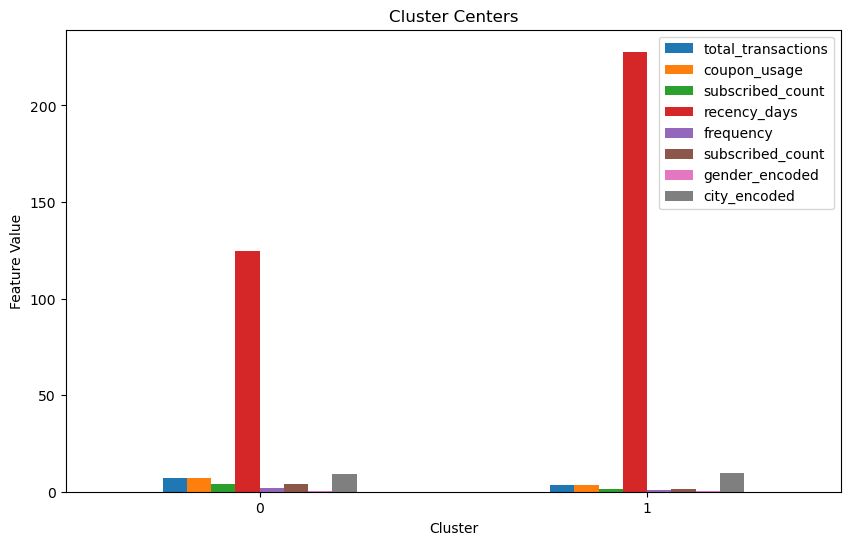

In [41]:
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)

cluster_centers.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Centers')
plt.xlabel('Cluster')
plt.ylabel('Feature Value')
plt.xticks(rotation=0)
plt.legend(loc='upper right')
plt.show()

In [42]:
print(final_data_with_clusters.columns)

Index(['customer_id', 'join_date', 'city_id', 'gender_id', 'gender_name',
       'city_name', 'total_transactions', 'last_transaction', 'coupon_usage',
       'subscribed_count', 'recency_days', 'frequency', 'gender_encoded',
       'city_encoded', 'cluster', 'total_transactions', 'coupon_usage',
       'subscribed_count', 'recency_days', 'frequency', 'subscribed_count',
       'gender_encoded', 'city_encoded'],
      dtype='object')


In [43]:
final_data_with_clusters = final_data_with_clusters.loc[:, ~final_data_with_clusters.columns.duplicated()]

cluster_summary = final_data_with_clusters.groupby('cluster').agg(
    total_customers=('customer_id', 'count'),
    avg_total_transactions=('total_transactions', 'mean'),
    avg_recency_days=('recency_days', 'mean'),
    avg_coupon_usage=('coupon_usage', 'mean'),
    avg_frequency=('frequency', 'mean'),
    most_common_city=('city_name', lambda x: x.mode()[0]),  # Most common city
    most_common_gender=('gender_name', lambda x: x.mode()[0])  # Most common gender
).reset_index()

print("Cluster Summary:")
print(cluster_summary)

Cluster Summary:
   cluster  total_customers  avg_total_transactions  avg_recency_days  \
0        0              406                7.093596        124.692118   
1        1              594                3.662646        227.796296   

   avg_coupon_usage  avg_frequency     most_common_city most_common_gender  
0          7.093596       2.054280                Cairo               Male  
1          3.569024       0.793315  El-Mahalla El-Kubra               Male  


## ***Evaluate the model***

In [46]:
print(f"Silhouette Score: {silhouette_score(scaled_features, final_data['cluster'])}")
print(f"Davies-Bouldin Index: {davies_bouldin_score(scaled_features, final_data['cluster'])}")

Silhouette Score: 0.2818606194427689
Davies-Bouldin Index: 1.3130314965388648


## ***Business report***

In [49]:
report = ""
for i in range(k_optimal):
    cluster = cluster_summary.loc[cluster_summary['cluster'] == i]
    report += f"\n**Cluster {i} Analysis:**\n"
    report += f"- **Total Customers**: {cluster['total_customers'].values[0]}\n"
    report += f"- **Average Transactions**: {cluster['avg_total_transactions'].values[0]:.2f}\n"
    report += f"- **Average Recency (Days)**: {cluster['avg_recency_days'].values[0]:.2f}\n"
    report += f"- **Coupon Usage**: {cluster['avg_coupon_usage'].values[0]:.2f}\n"
    report += f"- **Frequency**: {cluster['avg_frequency'].values[0]:.2f}\n"
    report += f"- **Most Common City**: {cluster['most_common_city'].values[0]}\n"
    report += f"- **Most Common Gender**: {cluster['most_common_gender'].values[0]}\n"
    if cluster['avg_coupon_usage'].values[0] < 1:
        report += "- **Recommendation**: Provide more coupons to boost engagement in this segment.\n"
    else:
        report += "- **Recommendation**: Focus on loyalty programs to retain customers in this segment.\n"

print(report)


**Cluster 0 Analysis:**
- **Total Customers**: 406
- **Average Transactions**: 7.09
- **Average Recency (Days)**: 124.69
- **Coupon Usage**: 7.09
- **Frequency**: 2.05
- **Most Common City**: Cairo
- **Most Common Gender**: Male
- **Recommendation**: Focus on loyalty programs to retain customers in this segment.

**Cluster 1 Analysis:**
- **Total Customers**: 594
- **Average Transactions**: 3.66
- **Average Recency (Days)**: 227.80
- **Coupon Usage**: 3.57
- **Frequency**: 0.79
- **Most Common City**: El-Mahalla El-Kubra
- **Most Common Gender**: Male
- **Recommendation**: Focus on loyalty programs to retain customers in this segment.

